# ENV / ATM 415: Climate Laboratory

# Exercises on Radiative-Convective Equilibrium with `climlab`

Tuesday April 5, 2016

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import climlab

## First, let's just repeat the calculations we did in the previous notebook `RadiativeConvectiveEquilibrium.ipynb`

(Just by copying and pasting the relevant code)

In [2]:
ncep_filename = 'air.mon.1981-2010.ltm.nc'
# This will try to read the data over the internet.
#ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
#ncep_air = nc.Dataset( ncep_url + 'pressure/' + ncep_filename )
# Or to read from local disk
ncep_air = nc.Dataset( ncep_filename )

level = ncep_air.variables['level'][:]
lat = ncep_air.variables['lat'][:]
# A log-pressure height coordinate
zstar = -np.log(level/1000)

In [3]:
#  Take averages of the temperature data
Tzon = np.mean(ncep_air.variables['air'][:],axis=(0,3))
Tglobal = np.average( Tzon , weights=np.cos(np.deg2rad(lat)), axis=1) + climlab.constants.tempCtoK
#  Note the useful conversion factor. climlab.constants has lots of commonly used constant pre-defined

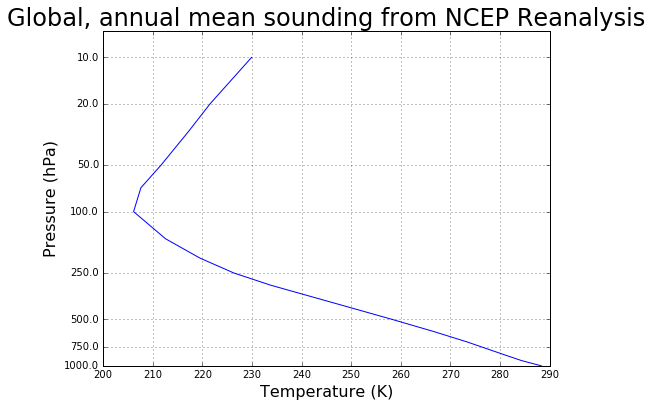

In [4]:
#  Here we are plotting with respect to log(pressure) but labeling the axis in pressure units
fig = plt.figure( figsize=(8,6) )
ax = fig.add_subplot(111)
ax.plot( Tglobal , zstar )
yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
ax.set_yticks(-np.log(yticks/1000.))
ax.set_yticklabels(yticks)
ax.set_xlabel('Temperature (K)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean sounding from NCEP Reanalysis', fontsize = 24)
ax.grid()

In [5]:
#  Repeating code from previous notebook ...  set up a column model with observed temperatures.

#  initialize a grey radiation model with 30 levels
col = climlab.GreyRadiationModel()
# interpolate to 30 evenly spaced pressure levels
lev = col.lev
Tinterp = np.interp(lev, np.flipud(level), np.flipud(Tglobal))
# Initialize model with observed temperatures
col.Ts[:] = Tglobal[0]
col.Tatm[:] = Tinterp
#  The tuned value of absorptivity
eps = 0.0534
#  set it
col.subprocess.LW.absorptivity = eps

In [6]:
#  Pure radiative equilibrium

#  Make a clone of our first model
re = climlab.process_like(col)
#  Run out to equilibrium
re.integrate_years(2.)
#  Check for energy balance
re.ASR - re.OLR

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


array([ -4.63536367e-07])

In [7]:
#  And set up a RadiativeConvective model, 
rce = climlab.RadiativeConvectiveModel(adj_lapse_rate=6.)
# Set our tuned absorptivity value
rce.subprocess.LW.absorptivity = eps
#  Run out to equilibrium
rce.integrate_years(2.)
#  Check for energy balance
rce.ASR - rce.OLR

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.99867375676 years.


array([  1.96076849e-06])

In [8]:
#  A handy re-usable routine for making a plot of the temperature profiles
#  We will plot temperatures with respect to log(pressure) to get a height-like coordinate
def plot_sounding(collist):
    color_cycle=['r', 'g', 'b', 'y', 'm']
    # col is either a column model object or a list of column model objects
    if isinstance(collist, climlab.Process):
        # make a list with a single item
        collist = [collist]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i, col in enumerate(collist):
        zstar = -np.log(col.lev/climlab.constants.ps)
        ax.plot(col.Tatm, zstar, color=color_cycle[i])
        ax.plot(col.Ts, 0, 'o', markersize=12, color=color_cycle[i])
    #ax.invert_yaxis()
    yticks = np.array([1000., 750., 500., 250., 100., 50., 20., 10.])
    ax.set_yticks(-np.log(yticks/1000.))
    ax.set_yticklabels(yticks)
    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('Pressure (hPa)')
    ax.grid()
    return ax

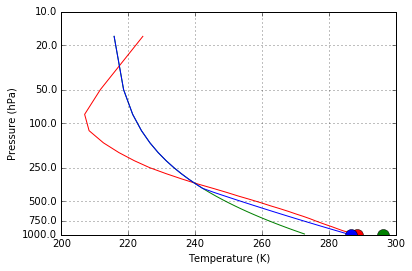

In [9]:
#  Make a plot to compare observations and Radiative-Convective Equilibrium
plot_sounding([col, re, rce])

#  Stratospheric ozone

In [10]:
#  To read from internet
#datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/som_input/"
#endstr = "/entry.das"

ozone_filename = 'ozone_1.9x2.5_L26_2000clim_c091112.nc'
datapath = ''
endstr = ''

ozone = nc.Dataset( datapath + ozone_filename + endstr )


In [11]:
print ozone.variables['O3']

<type 'netCDF4._netCDF4.Variable'>
float32 O3(time, lev, lat, lon)
    units: mol/mol
    long_name: O3 concentration
    cell_method: time: mean
unlimited dimensions: time
current shape = (12, 26, 96, 144)
filling off



In [12]:
lat = ozone.variables['lat'][:]
lon = ozone.variables['lon'][:]
lev = ozone.variables['lev'][:]


The pressure levels in this dataset are:

In [13]:
print lev

[   3.544638     7.3888135   13.967214    23.944625    37.23029     53.114605
   70.05915     85.439115   100.514695   118.250335   139.115395   163.66207
  192.539935   226.513265   266.481155   313.501265   368.81798    433.895225
  510.455255   600.5242     696.79629    787.70206    867.16076    929.648875
  970.55483    992.5561   ]


Take the global average of the ozone climatology, and plot it as a function of pressure (or height)

In [14]:
O3_zon = np.mean( ozone.variables['O3'],axis=(0,3) )
O3_global = np.sum( O3_zon * np.cos(np.deg2rad(lat)), axis=1 ) / np.sum( np.cos(np.deg2rad(lat) ) )


In [15]:
O3_global.shape

(26,)

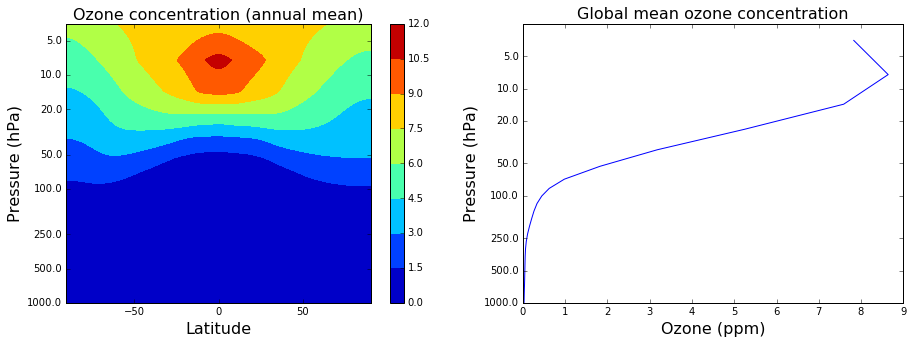

In [16]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,2,1)
cax = ax1.contourf(lat, np.log(lev/climlab.constants.ps), O3_zon * 1.E6)
ax1.invert_yaxis()
ax1.set_xlabel('Latitude', fontsize=16)
ax1.set_ylabel('Pressure (hPa)', fontsize=16 )
yticks = np.array([1000., 500., 250., 100., 50., 20., 10., 5.])
ax1.set_yticks( np.log(yticks/1000.) )
ax1.set_yticklabels( yticks )
ax1.set_title('Ozone concentration (annual mean)', fontsize = 16);
plt.colorbar(cax)

ax2 = fig.add_subplot(1,2,2)
ax2.plot( O3_global * 1.E6, np.log(lev/climlab.constants.ps) )
ax2.invert_yaxis()
ax2.set_xlabel('Ozone (ppm)', fontsize=16)
ax2.set_ylabel('Pressure (hPa)', fontsize=16 )
yticks = np.array([1000., 500., 250., 100., 50., 20., 10., 5.])
ax2.set_yticks( np.log(yticks/1000.) )
ax2.set_yticklabels( yticks )
ax2.set_title('Global mean ozone concentration', fontsize = 16);

This shows that most of the ozone is indeed in the stratosphere, and peaks near the top of the stratosphere.

# The `BandRCModel`: a radiative model with individual spectral bands

Here is a brief introduction to the `climlab.BandRCModel` process.

This is a model that divides the spectrum into 7 distinct bands: three shortwave and four longwave.

As we will see, the process works much like the familiar `climlab.RadiativeConvectiveModel`.


## About the spectra

The shortwave is divided into three channels:

- Channel 0 is the Hartley and Huggins band (extreme UV, 200 - 340 nm, 1% of total flux, strong ozone absorption)
- Channel 1 is Chappuis band (450 - 800 nm, 27% of total flux, moderate ozone absorption)
- Channel 2 is remaining radiation (72% of total flux, largely in the visible range, no ozone absorption)

The longwave is divided into four bands:

- Band 0 is the window region (between 8.5 and 11 $\mu$m), 17% of total flux.
- Band 1 is the CO2 absorption channel (the band of strong absorption by CO2 around 15 $\mu$m), 15% of total flux
- Band 2 is a weak water vapor absorption channel, 35% of total flux
- Band 3 is a strong water vapor absorption channel, 33% of total flux

The longwave decomposition is not as easily related to specific wavelengths, as in reality there is a lot of overlap between H$_2$O and CO$_2$ absorption features (as well as absorption by other greenhouse gases such as CH$_4$ and N$_2$O that we are not representing).

##  Create a Radiative-Convective model using these spectral bands, and put in some ozone

Now create a new column model object on the **same pressure levels as the ozone data**. We are also going set an adjusted lapse rate of 6 K / km, and tune the longwave absorption

In [17]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
band1 = climlab.BandRCModel(lev=lev, adj_lapse_rate=6)
print band1

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



Check out the list of subprocesses.

We now have a process called `H2O`, in addition to things we've seen before.

This model keeps track of water vapor. More on that later!

### About the radiatively active gases

The Band model is aware of three different absorbing gases: O3 (ozone), CO2, and H2O (water vapor). The abundances of these gases are stored in a dictionary of arrays as follows:

In [18]:
band1.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038]),
 'H2O': Field([ 0.00041834,  0.00031609,  0.00025918,  0.00023079,  0.00022334,
         0.00023235,  0.00025805,  0.00030617,  0.00037214,  0.00044727,
         0.00053183,  0.00062593,  0.00072953,  0.00084236,  0.00096401,
         0.00109382,  0.00123101,  0.00137459,  0.00152342,  0.00167623,
         0.00185712,  0.00209789,  0.00241807,  0.00284451,  0.00341587,
         0.00416384]),
 'O3': Field([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

Ozone and CO2 are both specified in the model. The default, as you see above, is zero ozone, and constant (well-mixed) CO2 at a volume mixing ratio of 3.8E-4 or 380 ppm.

Water vapor is handled differently: it is determined by the model at each timestep. We make the following assumptions, following a classic paper on radiative-convective equilibrium by Manabe and Wetherald (J. Atmos. Sci. 1967):

- the relative humidity just above the surface is fixed at 77% (can be changed of course... see the parameter `col1.relative_humidity`
- water vapor drops off linearly with pressure
- there is a small specified amount of water vapor in the stratosphere.

## Radiative-convective equilibrium in the band model without ozone

In [19]:
band1.state

{'Tatm': Field([ 200.  ,  203.12,  206.24,  209.36,  212.48,  215.6 ,  218.72,
         221.84,  224.96,  228.08,  231.2 ,  234.32,  237.44,  240.56,
         243.68,  246.8 ,  249.92,  253.04,  256.16,  259.28,  262.4 ,
         265.52,  268.64,  271.76,  274.88,  278.  ]), 'Ts': Field([ 288.])}

In [20]:
band1.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.99867375676 years.


In [21]:
# Check for energy balance
band1.ASR - band1.OLR

array([-0.00314361])

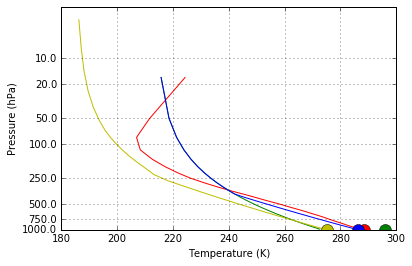

In [22]:
#  Add another line to our graph!
plot_sounding([col, re, rce, band1])

### Now put in the ozone

In [23]:
band2 = climlab.process_like(band1)
print band2

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [24]:
band2.absorber_vmr['O3'] = O3_global
band2.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038]),
 'H2O': Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.72815749e-06,   8.48236360e-06,   1.57838825e-05,
          3.35068061e-05,   6.90960430e-05,   1.38620761e-04,
          2.70931380e-04,   5.16536496e-04,   9.13087173e-04,
          1.43993837e-03,   2.03985499e-03,   2.61271071e-03,
          3.03933387e-03,   3.28641981e-03]),
 'O3': array([  7.82792878e-06,   8.64150531e-06,   7.58940016e-06,
          5.24567137e-06,   3.17761577e-06,   1.82320007e-06,
          9.

In [25]:
#  Run the model out to equilibrium!
band2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 3.99734751351 years.


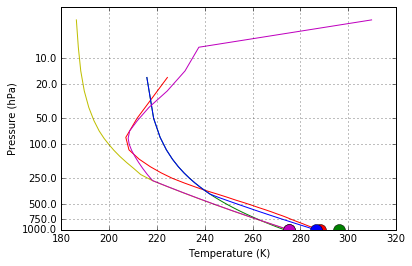

In [26]:
#  Add another line to our graph!
plot_sounding([col, re, rce, band1, band2])

Once we include ozone we get a well-defined stratosphere. 

Things to consider / try:

- Here we used the global annual mean Q = 341.3 W m$^{-2}$. We might want to consider latitudinal or seasonal variations in Q.
- We also used the global annual mean ozone profile! Ozone varies tremendously in latitude and by season. That information is all contained in the ozone data file we opened above. We might explore the effects of those variations.
- We can calculate climate sensitivity in this model by doubling the CO2 concentration and re-running out to the new equilibrium. Does the amount of ozone affect the climate sensitivity?  (example below)
- An important shortcoming of the model: there are no clouds! (that would be the next step in the hierarchy of column models)
- Clouds would act both in the shortwave (increasing the albedo, cooling the climate) and in the longwave (greenhouse effect, warming the climate). Which effect is stronger depends on the vertical structure of the clouds (high or low clouds) and their optical properties (e.g. thin cirrus clouds are nearly transparent to solar radiation but are good longwave absorbers).

# Climate sensitivity to doubling CO2

We now actually have a model that is aware of the amount of atmospheric CO2:

In [27]:
band2.absorber_vmr['CO2']

Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
        0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
        0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
        0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
        0.00038,  0.00038])

In [28]:
# Let's double CO2 and calculate radiative forcing
band3 = climlab.process_like(band2)
band3.absorber_vmr['CO2'] *= 2.
band3.absorber_vmr['CO2']

Field([ 0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
        0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
        0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
        0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
        0.00076,  0.00076])

We've just increased CO2 from 380 ppm to 760 ppm.

Radiative forcing is the instantaneous change in OLR...

In [29]:
band3.compute_diagnostics()
print 'The radiative forcing for doubling CO2 is %f W/m2.' % (band2.OLR - band3.OLR)

The radiative forcing for doubling CO2 is 1.535000 W/m2.


In [30]:
#  and make another copy, which we will integrate out to equilibrium
band4 = climlab.process_like(band3)
band4.integrate_years(3)
band4.ASR - band4.OLR

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 6.99535814865 years.


array([  8.36980604e-07])

In [31]:
DeltaT = band4.Ts - band2.Ts
print 'The Equilibrium Climate Sensitivity is %f K.' % DeltaT

The Equilibrium Climate Sensitivity is 2.829001 K.


## Investigating the role of water vapor feedback in climate sensitivity

Let's make some plots of the vertical profiles of water vapor before and after the climate change.

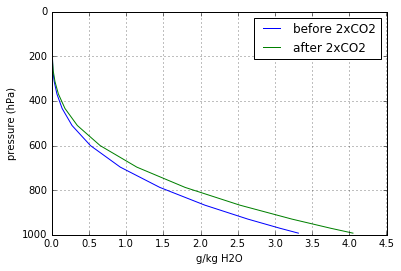

In [32]:
#  We multiply the H2O mixing ratio by 1000 to get units of g / kg
#  (amount of water vapor per mass of air)
plt.plot( band2.absorber_vmr['H2O'] *1000, lev, label='before 2xCO2')
plt.plot( band4.absorber_vmr['H2O'] * 1000., lev, label='after 2xCO2')
plt.xlabel('g/kg H2O')
plt.ylabel('pressure (hPa)')
plt.legend(loc='upper right')
plt.grid()
#  This reverses the axis so pressure decreases upward
plt.gca().invert_yaxis()

Water vapor decreases from the surface upward mostly because the temperature decreases!

Our model uses a parameterization that holds the **relative humidity** to a fixed profile. Since the saturation point increases strongly with temperature, the actual amount of water vapor increases as the climate warms to preserve the relative humidity.

We can see this increase in the graph above.

## Removing the fixed-relative-humidity water vapor subprocess

Make a new model that does NOT have a water vapor feedback. Hold the H2O amount fixed as we warm.

In [33]:
#  First, make a new clone
noh2o = climlab.process_like(band2)

In [34]:
#  See what absorbing gases are currently present
noh2o.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038]),
 'H2O': Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.82819338e-06,   6.63658736e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.81052164e-06,   7.30667103e-06,
          9.31673298e-06,   1.20405663e-05,   1.59719937e-05,
          3.38913986e-05,   6.98600830e-05,   1.40097861e-04,
          2.73714160e-04,   5.21651820e-04,   9.21834609e-04,
          1.45336296e-03,   2.05847334e-03,   2.63619532e-03,
          3.06639616e-03,   3.31553867e-03]),
 'O3': array([  7.82792878e-06,   8.64150531e-06,   7.58940016e-06,
          5.24567137e-06,   3.17761577e-06,   1.82320007e-06,
          9.

In [35]:
#  double the CO2 !
noh2o.absorber_vmr['CO2'] *= 2

In [36]:
#  Check out the list of subprocesses
print noh2o

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [37]:
#  Remove the process that changes the H2O
noh2o.remove_subprocess('H2O')
print noh2o

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



Notice that the subprocess labelled `'H2O'` is gone from the list.

This was the process that modified the water vapor. But note that the model still contains H2O:

In [38]:
noh2o.absorber_vmr

{'CO2': Field([ 0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
         0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
         0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
         0.00076,  0.00076,  0.00076,  0.00076,  0.00076,  0.00076,
         0.00076,  0.00076]),
 'H2O': Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.82819338e-06,   6.63658736e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.81052164e-06,   7.30667103e-06,
          9.31673298e-06,   1.20405663e-05,   1.59719937e-05,
          3.38913986e-05,   6.98600830e-05,   1.40097861e-04,
          2.73714160e-04,   5.21651820e-04,   9.21834609e-04,
          1.45336296e-03,   2.05847334e-03,   2.63619532e-03,
          3.06639616e-03,   3.31553867e-03]),
 'O3': array([  7.82792878e-06,   8.64150531e-06,   7.58940016e-06,
          5.24567137e-06,   3.17761577e-06,   1.82320007e-06,
          9.

But this will be held fixed now as the climate changes in `noh2o`.

Let's go ahead and run it out to equilibrium.

In [39]:
noh2o.integrate_years(3)
noh2o.ASR - noh2o.OLR

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 6.99535814865 years.


array([ -4.80395101e-09])

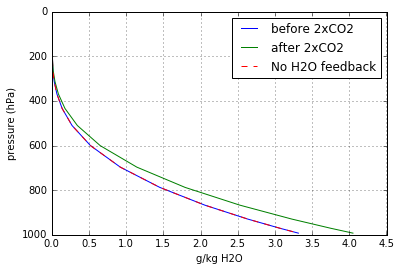

In [40]:
#  Repeat the same plot of water vapor profiles, but add a third curve
#  We'll plot the new model as a dashed line to make it easier to see.
plt.plot( band2.absorber_vmr['H2O'] *1000, lev, label='before 2xCO2')
plt.plot( band4.absorber_vmr['H2O'] * 1000., lev, label='after 2xCO2')
plt.plot( noh2o.absorber_vmr['H2O'] * 1000., lev, linestyle='--', label='No H2O feedback')
plt.xlabel('g/kg H2O')
plt.ylabel('pressure (hPa)')
plt.legend(loc='upper right')
plt.grid()
#  This reverses the axis so pressure decreases upward
plt.gca().invert_yaxis()

Indeed, the water vapor is identical in the new equilibrium climate to the old pre-CO2-increase model. 

So this model does NOT have a water vapor feedback.

How does this affect the climate sensivity?

In [41]:
DeltaT_noh2o = noh2o.Ts - band2.Ts
print 'The Equilibrium Climate Sensitivity with water vapor feedback is %f K.' % DeltaT_noh2o

The Equilibrium Climate Sensitivity with water vapor feedback is 1.798071 K.


So the effect of the water vapor feedback on the climate sensitivity to doubled CO2 is:

In [42]:
DeltaT - DeltaT_noh2o

Field([ 1.03093029])

We get about an additional degree of warming from the water vapor increase.

## MORE MESSING AROUND

In [183]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
tuneband = climlab.BandRCModel(lev=lev, adj_lapse_rate=6, albedo_sfc=0.1)
print tuneband

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (26,) 
  Ts: (1,) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [184]:
tuneband.absorber_vmr['O3'] = O3_global

In [185]:
tuneband.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038]),
 'H2O': Field([ 0.00041834,  0.00031609,  0.00025918,  0.00023079,  0.00022334,
         0.00023235,  0.00025805,  0.00030617,  0.00037214,  0.00044727,
         0.00053183,  0.00062593,  0.00072953,  0.00084236,  0.00096401,
         0.00109382,  0.00123101,  0.00137459,  0.00152342,  0.00167623,
         0.00185712,  0.00209789,  0.00241807,  0.00284451,  0.00341587,
         0.00416384]),
 'O3': array([  7.82792878e-06,   8.64150531e-06,   7.58940016e-06,
          5.24567137e-06,   3.17761577e-06,   1.82320007e-06,
          9.80756956e-07,   6.22870520e-07,   4.47620550e-07,
          3.34481165e-07,   2.62570301e-07,   2.07898124e-07,
          1.57074554e-07,   1.12425544e-07

In [186]:
tuneband.compute_diagnostics()

In [187]:
tuneband.absorber_vmr

{'CO2': Field([ 0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038,  0.00038,  0.00038,  0.00038,  0.00038,
         0.00038,  0.00038]),
 'H2O': Field([  5.00000000e-06,   5.00000000e-06,   5.00000000e-06,
          5.00000000e-06,   5.00000000e-06,   7.85107006e-06,
          1.31816258e-05,   2.04443889e-05,   3.05742708e-05,
          4.48409701e-05,   6.46415045e-05,   9.17579776e-05,
          1.28441493e-04,   1.77509570e-04,   2.42458332e-04,
          3.27590801e-04,   4.38162609e-04,   5.80546339e-04,
          7.62415731e-04,   9.92950889e-04,   1.28254570e-03,
          1.64341929e-03,   2.09029713e-03,   2.64031177e-03,
          3.31323455e-03,   4.13220797e-03]),
 'O3': array([  7.82792878e-06,   8.64150531e-06,   7.58940016e-06,
          5.24567137e-06,   3.17761577e-06,   1.82320007e-06,
          9.

In [188]:
tuneband.subprocess.LW.absorption_cross_section

{'CO2': array([[ 0.        ],
        [ 1.03157895],
        [ 0.        ],
        [ 0.        ]]), 'H2O': array([[ 0.    ],
        [ 0.    ],
        [ 0.0686],
        [ 4.9   ]]), 'O3': array([[ 13.72],
        [  0.  ],
        [  0.  ],
        [  0.  ]])}

In [189]:
#  This set of parameters gives correct Ts and ASR
#   But seems weird... the radiative forcing for doubling CO2 is tiny
#tuneband.subprocess.SW.reflectivity[15] = 0.255
#tuneband.subprocess.LW.absorption_cross_section['CO2'][1] = 2.
#tuneband.subprocess.LW.absorption_cross_section['H2O'][2] = 0.45

In [240]:
#  Just tune the surface albedo, won't get correct ASR but get correct Ts
tuneband = climlab.BandRCModel(lev=lev, adj_lapse_rate=6, albedo_sfc=0.22)

In [241]:
tuneband.integrate_converge()

Total elapsed time is 4.99668439189 years.


In [242]:
tuneband.Ts

Field([ 287.65936792])

In [243]:
tuneband.ASR

array([ 270.01721362])

In [244]:
tuneband.OLR

array([ 270.01721362])

In [245]:
tuneband.param

{'Q': 341.3,
 'abs_coeff': 0.0001229,
 'adj_lapse_rate': 6,
 'albedo_sfc': 0.22,
 'timestep': 86400.0,
 'water_depth': 1.0}

In [246]:
tband2 = climlab.process_like(tuneband)

In [247]:
tband2.subprocess['LW'].absorber_vmr['CO2'] *= 2

In [248]:
tband2.compute_diagnostics()

In [249]:
tband2.OLR

array([ 264.47795732])

In [250]:
tband2.step_forward()

In [251]:
tband2.OLR

array([ 264.47795732])

In [252]:
tband2.integrate_converge()

Total elapsed time is 9.99610669304 years.


In [253]:
tband2.Ts

Field([ 291.98764228])

In [254]:

ncep_air

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format UNDEFINED):
    description:  Data from NCEP initialized reanalysis (4x/day).  These are interpolated to pressure surfaces from model (sigma) surfaces.
    platform: Model
    Conventions: COARDS
    not_missing_threshold_percent: minimum 3% values input to have non-missing output value
    history: Created 2011/07/12 by doMonthLTM
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly ltm air from the NCEP Reanalysis
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.derived.html
    dimensions(sizes): lon(144), lat(73), level(17), time(12), nbnds(2)
    variables(dimensions): float32 level(level), float32 lat(lat), float32 lon(lon), float64 time(time), float64 climatology_bounds(time,nbnds), float32 air(time,level,lat,lon), float32 valid_yr_count(time,level,lat,lon)
    groups: 

In [255]:
ncep_air.variables.keys()

[u'level',
 u'lat',
 u'lon',
 u'time',
 u'climatology_bounds',
 u'air',
 u'valid_yr_count']

In [256]:
latmodel = climlab.BandRCModel(lat=lat, lev=lev, adj_lapse_rate=6, albedo_sfc=0.22)
print latmodel

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>



In [258]:
latmodel.Tatm.shape

(96, 26)

In [259]:
ncep_air.variables['air'].shape

(12, 17, 73, 144)

In [261]:
tuneband.Ts

Field([ 287.65936792])

In [263]:
tuneband.subprocess.SW.albedo_sfc = 0.4

In [264]:
tuneband.integrate_converge()

Total elapsed time is 10.9927056622 years.


In [265]:
tuneband.Ts

Field([ 260.08872516])

In [266]:
tuneband.

In [267]:
#  make a model on the same grid as the ozone
model = climlab.BandRCModel(lev=lev, lat=lat, albedo_sfc=0.22)
insolation = climlab.radiation.insolation.AnnualMeanInsolation(domains=model.Ts.domain)
model.add_subprocess('insolation', insolation)
model.subprocess.SW.flux_from_space = model.subprocess.insolation.insolation
print model

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Tatm: (96, 26) 
  Ts: (96, 1) 
The subprocess tree: 
top: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.AnnualMeanInsolation'>



In [269]:
model.subprocess.insolation.insolation

array([[ 173.71993914],
       [ 173.92434149],
       [ 174.53503258],
       [ 175.5574257 ],
       [ 176.99863623],
       [ 178.86910604],
       [ 181.18324939],
       [ 183.96105065],
       [ 187.22944147],
       [ 191.02560147],
       [ 195.40297286],
       [ 200.4450058 ],
       [ 206.30771663],
       [ 213.44201356],
       [ 221.5783636 ],
       [ 230.2084302 ],
       [ 239.12259251],
       [ 248.190955  ],
       [ 257.32240619],
       [ 266.44858025],
       [ 275.51580556],
       [ 284.4805116 ],
       [ 293.30639093],
       [ 301.96254624],
       [ 310.42223018],
       [ 318.66196102],
       [ 326.66088633],
       [ 334.40031556],
       [ 341.86337086],
       [ 349.03472243],
       [ 355.90038539],
       [ 362.44756244],
       [ 368.66452061],
       [ 374.54049427],
       [ 380.06560805],
       [ 385.2308154 ],
       [ 390.02784939],
       [ 394.44918307],
       [ 398.48799756],
       [ 402.13815625],
       [ 405.39418395],
       [ 408.251